In [1]:
import pandas as pd
import supy as sp
import matplotlib.pyplot as plt
from functions.night import *
from functions.dict_legend import *
from scipy.stats import pearsonr, linregress
#from sklearn.linear_model import LinearRegression
in_folder = '../data/'
sp.show_version()

SuPy version: 2024.3.14.dev0
-------------


In [2]:
# Polynomial Regression
def polyfiter(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)
     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    correlation = np.corrcoef(x, y)[0,1]

     # r
    results['correlation'] = correlation
     # r-squared
    results['determination'] = correlation**2

    return results

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

In [3]:
s_rc = in_folder + 'saveairport_ECHSS/RunControl.nml'         # Input data from Säve airport.
df_state_init_save = sp.init_supy(s_rc)


2024-04-08 15:48:56,453 - SuPy - INFO - All cache cleared.


In [4]:
# Metdata
grid = df_state_init_save.index[0]
df_forcing_save = sp.load_forcing_grid(s_rc, grid)


2024-04-08 15:48:57,841 - SuPy - INFO - All cache cleared.


In [5]:
# Load observation data
obsdata = pd.read_csv(in_folder + 'saveairport_base/Saeve_asphalt_QGmeasured_timeadjusted.csv',header=0, sep=';')
obsdata.index = pd.to_datetime('2004') + obsdata['dectime'].sub(1).apply(pd.Timedelta, unit='D').round('min')
#obsdata.index = pd.to_datetime({'year': obsdata['year'],'month':obsdata['month'],'day': obsdata['day']}) + pd.to_timedelta(obsdata['time'])

In [6]:
#testrun
df_output_save, df_state_final_save = sp.run_supy(df_forcing_save, df_state_init_save)

2024-04-08 15:49:02,636 - SuPy - INFO - ====================
2024-04-08 15:49:02,638 - SuPy - INFO - Simulation period:
2024-04-08 15:49:02,638 - SuPy - INFO -   Start: 2004-02-12 00:05:00
2024-04-08 15:49:02,639 - SuPy - INFO -   End: 2004-04-14 21:00:00
2024-04-08 15:49:02,640 - SuPy - INFO - 
2024-04-08 15:49:02,642 - SuPy - INFO - No. of grids: 1
2024-04-08 15:49:02,643 - SuPy - INFO - SuPy is running in serial mode
2024-04-08 15:52:42,244 - SuPy - INFO - Execution time: 219.6 s
2024-04-08 15:52:42,245 - SuPy - INFO - ====================



In [8]:
df_state_init_save['netradiationmethod']

ind_dim,0
grid,
1,1003


In [9]:
# Setting correct ground layer parameters (807 from ESTM coefficients, used in Lindberg et al. 2020)
# EHC as heat storage scheme
df_state_ehc = df_state_init_save.copy()
#df_state_ehc.storageheatmethod = 5

# modify the depth of the vertical layers
ar_depth = np.repeat(np.array([[0.06, 0.3, 0.5, 0.7, 0.01]]), 7, axis=0).flatten() #changed first layer to 0.06 from 0.05 due to instability
df_state_ehc.loc[:, "dz_surf"] = ar_depth

# modify the heat capacity of the vertical layers
ar_cp = np.repeat(np.array([[1.86, 1.86, 1.2, 1.2, 1.2]])*1e6, 7, axis=0).flatten()
df_state_ehc.loc[:, "cp_surf"] = ar_cp

# modify the thermal conductivity of the vertical layers
ar_k = np.repeat(np.array([[0.759, 0.759, 0.63, 0.63, 0.63]]) , 7, axis=0).flatten()
df_state_ehc.loc[:, "k_surf"] = ar_k

df_output_ehc, df_state_final = sp.run_supy(df_forcing_save, df_state_ehc)


2024-04-08 15:57:46,739 - SuPy - INFO - ====================
2024-04-08 15:57:46,740 - SuPy - INFO - Simulation period:
2024-04-08 15:57:46,741 - SuPy - INFO -   Start: 2004-02-12 00:05:00
2024-04-08 15:57:46,742 - SuPy - INFO -   End: 2004-04-14 21:00:00
2024-04-08 15:57:46,743 - SuPy - INFO - 
2024-04-08 15:57:46,744 - SuPy - INFO - No. of grids: 1
2024-04-08 15:57:46,745 - SuPy - INFO - SuPy is running in serial mode
2024-04-08 16:01:40,681 - SuPy - INFO - Execution time: 233.9 s
2024-04-08 16:01:40,682 - SuPy - INFO - ====================



Text(-175, 300, 'y = 1.01x + 1.06\nR$^{2}$ = 0.84')

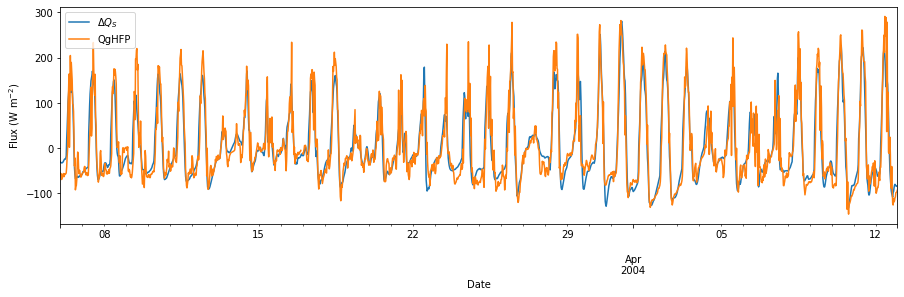

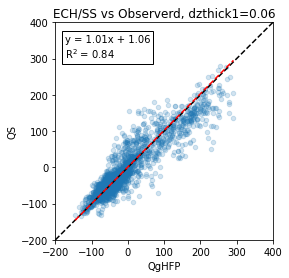

In [11]:
# Plot Qs with adjusted ground values vs observed values

new = df_output_ehc.SUEWS.loc[grid]
df_comp2 = pd.concat([obsdata,new]).resample('30Min').mean()
#df_comp2.loc[:,'QS'].plot(title='Testing Qs between ECH and observerd data')
#df_comp2.loc[:,'QgHFP'].plot()
start = '2004 3 06'
end = '2004 4 12'
ax_output = df_comp2.loc[start:end,['QS', 'QgHFP']].rename(columns=dict_var_disp)\
    .plot(figsize=(15, 4))
_ = ax_output.set_xlabel('Date')
_ = ax_output.set_ylabel('Flux ($ \mathrm{W \ m^{-2}}$)')
_ = ax_output.legend()

data = df_comp2.loc[start:end,['QS', 'QgHFP']].dropna()
# data = df_comp2

ax = data.loc[start:end].plot.scatter(x="QgHFP", y="QS", alpha=0.2, style="..", title='ECH/SS vs Observerd, dzthick1=' + str(ar_depth[0]))
_ = ax.set_aspect("equal", "box")
_ = ax.set_xlim(-200, 400)
_ = ax.set_ylim(-200, 400)
_ = ax.plot([-200, 400], [-200, 400], "k--")

poly4 = polyfiter(data.loc[start:end,'QS'], data.loc[start:end,'QgHFP'],1)    
ax.plot(data.loc[start:end,'QgHFP'].sort_values(), poly4['polynomial'][0] * data.loc[start:end,'QgHFP'].sort_values() + poly4['polynomial'][1], 'r--')    
    
ax.annotate("y = " + str(round(poly4['polynomial'][0], 2)) + "x + " + str(round(poly4['polynomial'][1], 2)) + 
             "\nR$^{2}$ = " + str(round(poly4['determination'], 2)), (-175, 300),ha='left', size=10, 
             bbox=dict(boxstyle="square", fc="none", ec="black"))

In [ ]:
# test to run with ECH and Spartacus
#s_rc_a1 = in_folder + 'saveairport_base/RunControl.nml'             # Input data from Säve airport. OHM and NARP
#s2_rc_a2 = in_folder + 'saveairport_NarpECH/RunControl.nml'         # Input data from Säve airport. ECH and NARP
s3_rc_a3 = in_folder + 'saveairport_ECHSS/RunControl.nml'          # Input data from Säve airport. ECH and SS

#df_state_init_a1 = sp.init_supy(s_rc_a1)
#df_state_init_a2 = sp.init_supy(s2_rc_a2)
df_state_init_a3 = sp.init_supy(s3_rc_a3)

#df_output_a1, df_state_final_a1 = sp.run_supy(df_forcing_save, df_state_init_a1)
#df_output_a2, df_state_final_a2 = sp.run_supy(df_forcing_save, df_state_init_a2)
df_output_a3, df_state_final_a3 = sp.run_supy(df_forcing_save, df_state_init_a3) #Crashing